In [21]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
from skimage import measure
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
from datetime import datetime as dt

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

Own modules available: ['conditionalstats', 'plot2D', 'plotCondPDFs', 'plot1D', 'conditionalstats_chunked']
Own modules available: ['fcns_load_DYAMOND_SAM', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF', 'casestudy', 'settings', 'fcns_load_RCEMIP_SAM', 'PrecipGrid']


In [23]:
import conditionalstats as cs
from plot2D import *

In [24]:
region = 'tropics'
path_regrid = os.path.join(DIR_DYAMOND_PROCESSED,region,'SAM','regridded')

In [25]:
figdir = os.path.join(os.path.dirname(workdir),'figures/multiscale_extremes',region)
os.makedirs(figdir,exist_ok=True)

In [26]:
prec_data = xr.open_dataset(os.path.join(path_regrid,'prec.nc'))

In [35]:
# Single-variable distributions
mean_prec = prec_data.mean_prec.values
dist_mean_prec = cs.Distribution(name="DYAMOND mean precipitation", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_mean_prec.computeDistribution(sample = mean_prec)
dist_mean_prec.storeBinLocations(sample = mean_prec,sizemax=1000)

max_prec = prec_data.max_prec.values
dist_max_prec = cs.Distribution(name="DYAMOND max precipitation", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_max_prec.computeDistribution(sample = max_prec)
dist_max_prec.storeBinLocations(sample = max_prec,sizemax=1000)

# Joint distribution
jdist_prec = cs.JointDistribution(name='Prec mean vs. max',distribution1=dist_mean_prec, distribution2=dist_max_prec)
jdist_prec.computeDistribution(sample1=mean_prec,sample2=max_prec)
jdist_prec.computeNormalizedDensity(sample1=mean_prec,sample2=max_prec)

In [28]:
LLS_data = xr.open_dataset(os.path.join(path_regrid,'LLS.nc'))['mean_LLS']

In [88]:
cond_varids = 'CWP', 'IWP', 'LHF', 'LLS', 'LLSU', 'LLSV', 'OM850', 'Prec', 'PW', 'RH500', 'RH850', 'SHF', 'T2mm', 'U10m', 'V10m'

cond_dict = dict()

for cvarid in cond_varids:
    
    cond_dict[cvarid] = {}
    
    print(cvarid)
    cond_data_mean = xr.open_dataset(os.path.join(path_regrid,'%s.nc'%cvarid))['mean_%s'%cvarid]
    cond_data_max = xr.open_dataset(os.path.join(path_regrid,'%s.nc'%cvarid))['max_%s'%cvarid]
    
    cond_dict[cvarid]['mean'] = jdist_prec.computeConditionalDataOverDensity(sample1=mean_prec,sample2=max_prec,data=cond_data_mean.values)
    cond_dict[cvarid]['max'] = jdist_prec.computeConditionalDataOverDensity(sample1=mean_prec,sample2=max_prec,data=cond_data_max.values)
    cond_dict[cvarid]['units'] = None
    
    # clear memory
    del cond_data_mean, cond_data_max
    gc.collect()
    

CWP
IWP
LHF
LLS
LLSU
LLSV
OM850
Prec
PW
RH500
RH850
SHF
T2mm
U10m
V10m


In [89]:
# Show conditional values

for cvarid in cond_varids:
    
    for func in 'mean','max':
    
        Z_nd = jdist_prec.norm_density.T
        Z = cond_dict[cvarid][func].T

        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

        title = '%s'%cvarid
        scale ='linear'
        vbds = (None, None)
        cmap = plt.cm.viridis

        ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

        # -- Frame
        ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
        ax.set_xlabel(r"1$^\circ\times 1$day extremes")
        ax.set_ylabel(r"4km-30mn extremes")
        ax.set_title(title)

        # -- Conditional mean values
        pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)


        # -- Branches
        cont = measure.find_contours(Z_nd, 1)    
        N = 60
        # fit
        popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
        x_branch_2 = y_branch_1 = np.linspace(2,45,45)
        y_branch_2 = func(x_branch_2,*popt_2)
        x_branch_1 = func(y_branch_1,*popt_1)

        # show
        ax_show.plot(x_branch_1,y_branch_1,'k--')
        ax_show.plot(x_branch_2,y_branch_2,'k--')

        cb = fig.colorbar(pcm, ax=ax_show)
        # cb.set_label('Normalized density')
        cb.set_label('')

        plt.savefig(os.path.join(figdir,'%s_%s_on_max_vs_mean_prec_extremes.pdf'%(cvarid,func)),bbox_inches='tight')
        plt.close()

/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked eleme

# LANDMASK

In [68]:
# LANDMASK - distribution of land, distribution of ocean separately

cvarid = 'LANDMASK'

# landmask data
landmask_rg = xr.open_dataset(os.path.join(path_regrid,'%s.nc'%cvarid))['mean_%s'%cvarid]
island = landmask_rg > 0.5
isocean = landmask_rg < 0.5
Nland = np.sum(island).values
Nocean = np.sum(isocean).values
Ntot = np.size(island)

# Count
bincount_land = jdist_prec.computeConditionalSum(sample1=mean_prec,sample2=max_prec,data=island.values)
bincount_ocean = jdist_prec.computeConditionalSum(sample1=mean_prec,sample2=max_prec,data=isocean.values)


In [69]:
Nland, Nocean, Ntot, Nland+Nocean

(array(121198), array(354002), 475200, 475200)

/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


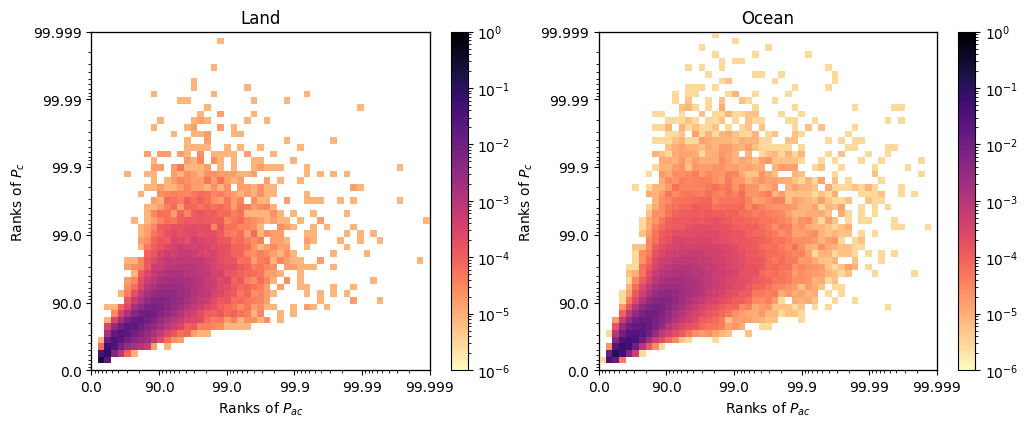

In [65]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4.4))

Z1 = bincount_land.T/Nland
Z2 = bincount_ocean.T/Nocean

titles = 'Land', 'Ocean'
scales = 'log','log'
vbounds = (1e-6,1),(1e-6,1)
cmaps = plt.cm.magma_r, plt.cm.magma_r

for ax,Z,title,scale,vbds,cmap in zip(axs,(Z1,Z2),titles,scales,vbounds,cmaps):

    ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

    # Frame
    ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
    ax.set_xlabel("Ranks of $P_{ac}$")
    ax.set_ylabel("Ranks of $P_{c}$")
    ax.set_title(title)

    # Content
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    
    fig.colorbar(pcm, ax=ax_show)
    
plt.savefig(os.path.join(figdir,'number_over_land_and_ocean_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()

/tmp/ipykernel_3105530/979033929.py:3: RuntimeWarning: divide by zero encountered in true_divide
  Z1 = bincount_land.T/Nland / (jdist_prec.bincount.T/Ntot)
/tmp/ipykernel_3105530/979033929.py:3: RuntimeWarning: invalid value encountered in true_divide
  Z1 = bincount_land.T/Nland / (jdist_prec.bincount.T/Ntot)
/tmp/ipykernel_3105530/979033929.py:4: RuntimeWarning: divide by zero encountered in true_divide
  Z2 = bincount_ocean.T/Nocean / (jdist_prec.bincount.T/Ntot)
/tmp/ipykernel_3105530/979033929.py:4: RuntimeWarning: invalid value encountered in true_divide
  Z2 = bincount_ocean.T/Nocean / (jdist_prec.bincount.T/Ntot)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildi

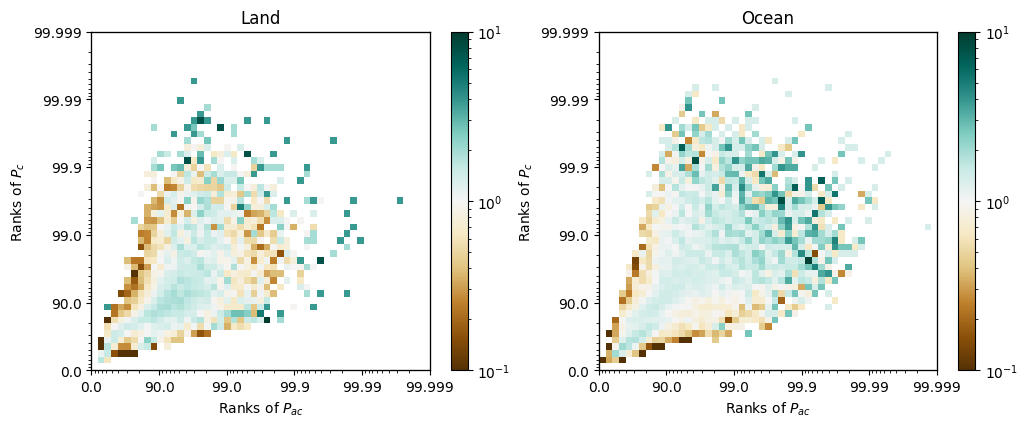

In [70]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4.4))

Z1 = bincount_land.T/Nland / (jdist_prec.bincount.T/Ntot)
Z2 = bincount_ocean.T/Nocean / (jdist_prec.bincount.T/Ntot)

titles = 'Land', 'Ocean'
scales = 'log','log'
# vbounds = (1,1e4),(1e-3,1e3)
vbounds = (1e-1,1e1),(1e-1,1e1)
# cmaps = plt.cm.magma_r, plt.cm.magma_r
cmaps = plt.cm.BrBG, plt.cm.BrBG

for ax,Z,title,scale,vbds,cmap in zip(axs,(Z1,Z2),titles,scales,vbounds,cmaps):

    ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

    # Frame
    ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
    ax.set_xlabel("Ranks of $P_{ac}$")
    ax.set_ylabel("Ranks of $P_{c}$")
    ax.set_title(title)

    # Content
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    
    fig.colorbar(pcm, ax=ax_show)
    
plt.savefig(os.path.join(figdir,'fraction_over_land_and_ocean_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()

## Best figure

In [77]:
def fitBranches(cont,N):

    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
    
    if cont.__class__ is list:
        seg_1 = np.flip(cont[0],axis=1)
    else:
        seg_1 = cont.allsegs[0][0]
        
    # Branch 1 -- end of contour (upward branch)
    xdata_1 = seg_1[-N:,0]
    y_1 = ydata_1 = seg_1[-N:,1]

    # fit
    popt_1, pcov_1 = curve_fit(func, ydata_1, xdata_1,p0=(-10,1,0))
    x_1 = func(ydata_1, *popt_1)
    
    # Branch 2 -- start of contour
    x_2 = xdata_2 = seg_1[:N,0]
    ydata_2 = seg_1[:N,1]

    # fit
    popt_2, pcov_2 = curve_fit(func, xdata_2, ydata_2,p0=(-10,1,0))
    y_2 = func(xdata_2, *popt_2)
    
    return popt_1, x_1, y_1, popt_2, x_2, y_2, func

/tmp/ipykernel_3105530/4253275135.py:5: RuntimeWarning: divide by zero encountered in true_divide
  Z_show = Z2/Z1
/tmp/ipykernel_3105530/4253275135.py:5: RuntimeWarning: invalid value encountered in true_divide
  Z_show = Z2/Z1
/tmp/ipykernel_3105530/3932774558.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  

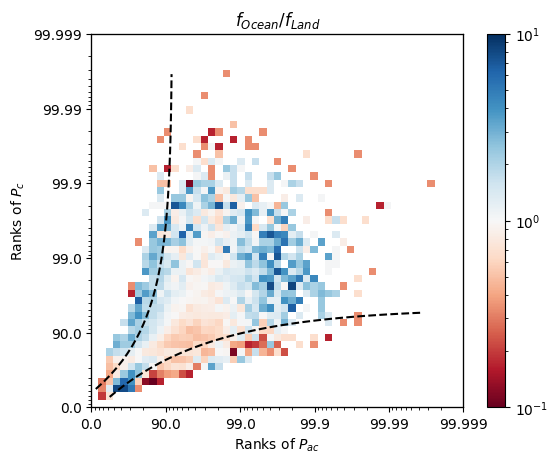

In [85]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z1 = bincount_land.T/Nland
Z2 = bincount_ocean.T/Nocean
Z_show = Z2/Z1
Z = jdist_prec.norm_density.T

title = r'$f_{Ocean}/f_{Land}$'
scale = 'log'
vbds = (1e-1,1e1)
cmap = plt.cm.RdBu

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel("Ranks of $P_{ac}$")
ax.set_ylabel("Ranks of $P_{c}$")
ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z_show, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    
# -- Branches

cont = measure.find_contours(Z, 1)

N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

fig.colorbar(pcm, ax=ax_show)
    
plt.savefig(os.path.join(figdir,'ratio_flocean_fland_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()